### Data Source
In this exercise we shall be using [The National Health and Nutrition Examination Surveys](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/overview.aspx?BeginYear=2015) (NHANES) dataset specifically the [nhanes 2015-2016](https://raw.githubusercontent.com/UMstatspy/UMStatsPy/master/NHANES/merged/nhanes_2015_2016.csv). Alternatively, the dataset can also be found at [nhanes 2015-2016](https://github.com/rashida048/Datasets/blob/master/nhanes_2015_2016.csv).

**Description of the variables can be found at [Data Processing and Editing](https://wwwn.cdc.gov/nchs/nhanes/2015-2016/DEMO_I.htm)**.

* **RIDAGEYR**: Age in years, at the time of the screening interview
* **RIDRETH1**: Race/Hispanic origin (1 = Mexican American, 3 = Non-Hispanic White, 4 = Non-Hispanic Black)
* **RIAGENDR**: Gender (1 = Male, 2 = Female)
* **SMQ020**: Smoker (1 = YES, 2 = NO)
* **BMXBMI**: Body Mass Index
* **BPXSY**(1 and 2): = Systolic Blood Pressure

#### Some Python Packages we shall be using

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.oneway import effectsize_oneway
import scikit_posthocs as sp
import os
from collections import Counter
%matplotlib inline
os.chdir('./resources/')

### Research Question 4
Considering **Mexican-American adults ages 18+** living in the United States in 2015-2016, did males have a significantly higher mean Body Mass Index (BMI) than females?

These measures are considered **independent** because they are different measurements (data) of the same variable taken from **different** object or group. This is therefore a test for **Difference in Population Means for Independent Groups**.

#### Information from Research Question
* Population: Mexican-American adults (ages 18+) living in the United States
* Parameter of Interest: Difference in mean BMI ($\mu_1 - \mu_2$) in $kg/m^2$
* Significance Level = 5%

#### State the null hypothesis and the alternative hypothesis
* Null Hypothesis H0: There is no difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States ($H_0: \mu_1 = \mu_2$)
* Alternative Hypothesis H1: There is a significant difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States ($H_1: \mu_1 \ne \mu_2$)

#### Hypothesis Test 
Perform a two samples **t-test** for **independent groups** for the difference in mean BMI between males and females. This will be a **two-tailed** or **non-directional** test since we are interested in the **difference** between both samples. 

#### Load the data

In [2]:
df = pd.read_csv('nhanes_2015_2016.csv')
print(f'Size of dataset = {df.shape}')
df.head()

Size of dataset = (5735, 28)


,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


#### Let's filter the required data
* Our variable of interest is **BMXBMI**
* Popupation (Ages 18+ and 'RIDRETH1' = 1 for Mexican-American)

In [3]:
df1 = df.copy()
df_bmi = df1[(df1['RIDAGEYR'] >= 18) & (df1['RIDRETH1'] == 1)][['RIAGENDR', 'BMXBMI']]
df_bmi.head()

,RIAGENDR,BMXBMI
5,2,28.6
7,2,28.2
16,2,32.8
23,2,22.8
29,2,33.5


**Let's check for missing values**

In [4]:
z = df_bmi.isnull().sum()
print(z[z > 0])

BMXBMI    18
dtype: int64


**We have `18`observations with missing data. We can safely drop these observation without hurting our data.**

In [5]:
df_bmi = df_bmi.dropna()
z = df_bmi.isnull().sum()
print(z[z > 0])

Series([], dtype: int64)


In [8]:
bmi_male = df_bmi[df_bmi['RIAGENDR'] == 1]['BMXBMI']
bmi_female = df_bmi[df_bmi['RIAGENDR'] == 2]['BMXBMI']

In [9]:
print(bmi_male.describe())

count    464.000000
mean      30.098276
std        6.483573
min       16.200000
25%       25.975000
50%       29.200000
75%       33.000000
max       58.800000
Name: BMXBMI, dtype: float64


In [10]:
print(bmi_female.describe())

count    536.000000
mean      31.716978
std        7.530061
min       16.200000
25%       26.975000
50%       30.150000
75%       35.300000
max       63.900000
Name: BMXBMI, dtype: float64


**Plot the groups and check that test assumptions are met**

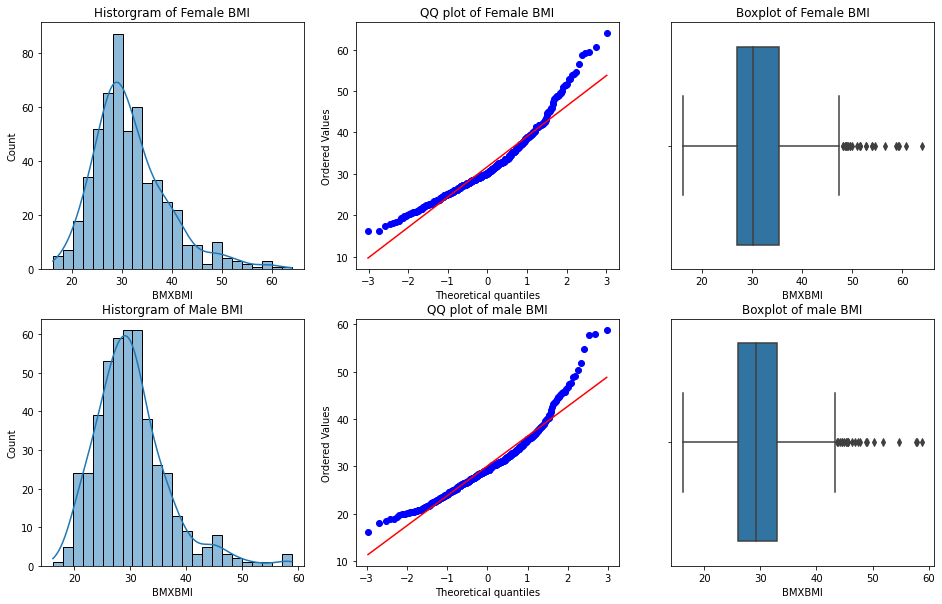

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (16, 10), sharex = False)
sns.histplot(bmi_female, kde = True, ax = axes[0,0])
axes[0,0].title.set_text('Historgram of Female BMI')
stats.probplot(bmi_female, dist = 'norm', plot = axes[0,1])              
axes[0,1].title.set_text('QQ plot of Female BMI')
sns.boxplot(x = bmi_female, ax = axes[0,2])
axes[0,2].title.set_text('Boxplot of Female BMI')

sns.histplot(bmi_male, kde = True, ax = axes[1,0])
axes[1,0].title.set_text('Historgram of Male BMI')
stats.probplot(bmi_male, dist = 'norm', plot = axes[1,1])              
axes[1,1].title.set_text('QQ plot of male BMI')
sns.boxplot(x = bmi_male, ax = axes[1,2])
axes[1,2].title.set_text('Boxplot of male BMI')

plt.show()

From the various plots we can concluded that with sufficient data and based on the **Central Limit Theorem (CLT)** that the sample is coming from a population that is normally distributed. We can go ahead with our analysis...
### Computing the t-Test Statistic (one measure taken from two separate groups)
The formula for computing the test statistic or **t value** for the **t-test for independent means** for two groups or distributions $x_1$ and $x_2$ is:

$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\left[\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}\right]\left[\frac{n_1 + n_2}{n_1n_2} \right]}}$    where

* $\bar{x_1}$ = is the mean for Group 1
* $\bar{x_2}$ = is the mean for Group 2
* $s_1^2$ = is the variance for Group 1
* $s_2^2$ = is the variance for Group 2
* $n_1$ = is the number of participants in Group 1
* $n_2$ = is the number of participants in Group 2

#### Helper function to compute t-value

In [12]:
def t_test(x1, x2):
    x1 = np.array(x1, dtype = np.float64)      # dtype = np.float64 is to address a Runtime Error
    x2 = np.array(x2, dtype = np.float64)
    n1 = len(x1)
    n2 = len(x2)
    s1 = np.var(x1)
    s2 = np.var(x2)
    x_bar1 = np.mean(x1)
    x_bar2 = np.mean(x2)
    return (x_bar1 - x_bar2) / np.sqrt(((((n1 - 1) * s1) + ((n2 - 1) * s2)) / (n1 + n2 - 2)) * ((n1 + n2) / (n1 * n2)))

**Compute the test statistic and critical-t value for decision.**

In [21]:
print(f'Mean Difference between male and female BMI = {round((bmi_male.mean() - bmi_female.mean()), 2)}')

Mean Difference between male and female BMI = -1.62


In [16]:
H0 = '"There is no difference between male and female mean BMI for Mexican-American adults (ages 18+) \
living in the United States in 2015-2016."'

H1 = '"There is a significant difference between male and female mean BMI for Mexican-American adults (ages 18+) \
living in the United States in 2015-2016."'

t_value = t_test(bmi_male, bmi_female)
print(f'test statistic(t) = {round(t_value, 3)}')

n1 = len(bmi_female)
n2 = len(bmi_male)
dof = (n1 - 1) + (n2 - 1)

alpha = 0.05
prob = 1 - alpha / 2                # two-tail test
critical_t = stats.t.ppf(prob, dof)           
print (f'critical-t = {round(critical_t, 4)}\n')

if abs(t_value) >= critical_t:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
    print(f'Accept the alternative or research hypothesis which states that:\n{H1}')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')

test statistic(t) = -3.617
critical-t = 1.9623

Significant outcome! Reject the null hypothesis which states that:
"There is no difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States in 2015-2016."

Accept the alternative or research hypothesis which states that:
"There is a significant difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States in 2015-2016."


#### Approach 2: Compute p-value for decision
We will use scipy's **`stats.ttest_ind`** to compute the **test statistic** and corresponding **p-value** for independent groups.

In [17]:
test_stat, pvalue = stats.ttest_ind(bmi_male, bmi_female)

print(f'test statistic = {round(test_stat, 3)}')
print(f'pvalue = {round(pvalue, 3)}\n')

if pvalue <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
    print(f'Accept the alternative or research hypothesis which states that:\n{H1}')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')

test statistic = -3.614
pvalue = 0.0

Significant outcome! Reject the null hypothesis which states that:
"There is no difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States in 2015-2016."

Accept the alternative or research hypothesis which states that:
"There is a significant difference between male and female mean BMI for Mexican-American adults (ages 18+) living in the United States in 2015-2016."


### Effect Size
**Effect size** is a measure of **how different two groups are from one another**. For example it’s a measure of the magnitude of the treatment given to one group that makes it significantly different from the other group. **Effect Size** would tell whether **statistically significant difference is also meaningful or not**.
##### Effect Size using `pooled variance`
The **pooled standard deviation is sort of an average of the standard deviation from Group 1 and the standard deviation from Group 2**.

$es = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}$    where

* $\bar{x_1}$ = is the mean for Group 1
* $\bar{x_2}$ = is the mean for Group 2
* $\sigma_1^2$ = is the variance for Group 1
* $\sigma_2^2$ = is the variance for Group 2

In [18]:
def effectSize(m1, m2, std1, std2):
    return (m1 - m2) / np.sqrt((std1 **2 + std2 ** 2) / 2)

In [19]:
m1 = np.mean(bmi_male)
m2 = np.mean(bmi_female)
std1 = np.std(bmi_male)
std2 = np.std(bmi_female)

d = effectSize(m1, m2, std1, std2)
print(f'Effect Size = {abs(round(d, 2))}')

Effect Size = 0.23


An effect size of **0.23** is categorized as **medium**. In addition to the **difference between the two means being statistically significant (pvalue < alpha) or test statistic being more extreme to the critical value**, one could conclude that the **difference also is meaningful** since the effect size is not negligible.

#### Confidence Interval
The **confidence interval** is calculated using the **student-t distribution** as follows:

$CI = \bar{x}_1-\bar{x}_2 \pm t_{critical}\sqrt{\frac{(n_1 - 1)s_1^2 +(n_2-1)s_2^2}{n_1 + n_2-2}}\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}$

* $\bar{x}_1$, $\bar{x}_2$ = sample means
* n1, n2 = sample sizes
* $t_{critical}$ = critical t-value from the t-distribution

In [20]:
x_bar1 = bmi_male.mean()
x_bar2 = bmi_female.mean()

s1 = bmi_male.std()
s2 = bmi_female.std()
n1 = len(bmi_male)
n2 = len(bmi_female)

alpha = 0.05
prob = 1 - alpha / 2

dof = np.min([(n1 - 1), (n2 - 1)])

standard_error = np.sqrt(((n1 - 1) * (s1 ** 2) + (n2 - 1) * (s2 ** 2))/(n1 + n2 - 2)) * np.sqrt(1/n1 + 1/n2)

critical_t = stats.t.ppf(prob, dof)
margin_of_error = critical_t * standard_error

# Calculate the lower and upper bound of the confidence interval
ci_lower = (x_bar1 - x_bar2) - margin_of_error
ci_upper = (x_bar1 - x_bar2) + margin_of_error

print(f'Point estimate(x_bar1 - x_bar2) = {round((x_bar1 - x_bar2), 2)}')
print(f'Critical-t = {round(critical_t, 3)}')
print(f'Margin of Error = {round(margin_of_error, 2)}')
print(f'Confidence Interval = {(round(ci_lower, 2), round(ci_upper, 2))}')

Point estimate(x_bar1 - x_bar2) = -1.62
Critical-t = 1.965
Margin of Error = 0.88
Confidence Interval = (-2.5, -0.74)


#### Interpretation of the results
With **95%** confidence, the **difference in mean Body Mass Index** between males and females for all Mexican-American adults (ages 18+) in the U.S is *estimated* to be between **-2.5 kg/$m^2$** and **-0.74 kg/$m^2$**. This means if this procedure were repeated over and over, each time computing the **95%** confidence interval estimate, we would expect **95% of those resulting `intervals` to contain the difference in population mean BMI**.

Our **best estimate ($\bar{x}_1-\bar{x}_2$) = -1.62 kg/$m^2$**  of the population parameter **lies in this range**.

### Research Question 5
Considering **Mexican-American adults (ages 18+)** living in the U.S in 2015-2016, did the **proportions of males and females who smoked vary significantly**?

#### Information from Research Question
* Population: Mexican-American adults (ages 18+) living in the United States
* Parameter of Interest: Proportion of smokers and non-smokers between male and female 
* Significance Level = 5%

#### State the null hypothesis and the alternative hypothesis
* Null Hypothesis H0: There was no difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016. ($H_0: p_1 = p_2$)
* Alternative Hypothesis H1: There is a significant difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016. ($H_0: p_1 \ne p_2$)

#### Hypothesis Test 
Perform a **chi-square test** to test for the difference in the two population proportions. 

#### Get the data
The variable or column in the **NHANES dataset** that provides this information is **SMQ020**.

In [29]:
df = pd.read_csv('nhanes_2015_2016.csv')
df2 = df.copy()
print(df2.SMQ020.unique())

[1 2 7 9]


In [30]:
print(df2.RIAGENDR.unique())

[1 2]


We'll create a new column to indicate **YES = smokers, NO = Non-smokers and `NaN` for others.**
We will also create a new column **Gender** from **RIAGENDR** to indicate **Male** and **Female** instead of **1** and **2**.

In [31]:
df2['SMOKER'] = df2.SMQ020.replace({1: 'YES', 2: 'NO', 7: np.nan, 9: np.nan})
df2['GENDER'] = df2.RIAGENDR.replace({1: 'Male', 2: 'Female'})

df_smoke_gender = df2[(df2['RIDAGEYR'] >= 18) & (df2['RIDRETH1'] == 1)][['SMOKER', 'GENDER']].dropna()
print(df_smoke_gender.shape)
df_smoke_gender.sample(5)

(1015, 2)


,SMOKER,GENDER
4784,YES,Female
1962,NO,Male
5512,YES,Male
3230,YES,Male
3712,YES,Male


#### Create cross tabulation table for categorical variables SMOKER and GENDER (contingency table)

In [32]:
table = pd.crosstab(df_smoke_gender.SMOKER, df_smoke_gender.GENDER)
table

GENDER,Female,Male
SMOKER,,
NO,431,240
YES,110,234


#### Using scipy's `stats.chi2_contingency` to obtain `pvalue`, `chi-square` statistic, `dof`, and `expected values`
**`stats.chi2_contingency`** accept a **contingency table** as argument.

In [35]:
H0 = '"There was no difference in the frequency of occurrences (proportions) between Mexican-American male and female \
smokers (ages 18+) living in the U.S in 2015-2016."'

H1 = '"There was a significant difference in the frequency of occurrences (proportions) between Mexican-American male and \
female smokers (ages 18+) living in the U.S in 2015-2016."'

alpha = 0.05

chi_sq_stat, p_value, dof, expected = stats.chi2_contingency(table)
print(f'chi-square = {round(chi_sq_stat, 3)}\ndof = {dof}\npvalue = {round(p_value, 3)}\n')

if p_value <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
    print(f'Accept the alternative or research hypothesis which states that:\n{H1}')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')

chi-square = 93.766
dof = 1
pvalue = 0.0

Significant outcome! Reject the null hypothesis which states that:
"There was no difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016."

Accept the alternative or research hypothesis which states that:
"There was a significant difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016."


**We can interpret the statistic by retrieving the critical value from the Chi-Squared distribution**

In [36]:
prob = 1 - alpha / 2                                    # 95% confidence level, two-tailed test
chi_crit = stats.chi2.ppf(prob, dof)
print(f'chi-critical = {round(chi_crit, 3)}\n')

if chi_sq_stat >= chi_crit:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
    print(f'Accept the alternative or research hypothesis which states that:\n{H1}')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')

chi-critical = 5.024

Significant outcome! Reject the null hypothesis which states that:
"There was no difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016."

Accept the alternative or research hypothesis which states that:
"There was a significant difference in the frequency of occurrences (proportions) between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016."


**Confidence Interval approach still using cross tabulation table**

In [37]:
ctable = pd.crosstab(df_smoke_gender.SMOKER, df_smoke_gender.GENDER, margins = True, margins_name = 'Total')
ctable

GENDER,Female,Male,Total
SMOKER,,,
NO,431,240,671
YES,110,234,344
Total,541,474,1015


**Compute Proportions of male and female smokers**

In [38]:
prop_male_smokers = ctable.loc['YES', 'Male'] / ctable.loc['Total', 'Male']
prop_female_smokers = ctable.loc['YES', 'Female'] / ctable.loc['Total', 'Female'] 

print(f'Proportion of Male Smokers = {round(prop_male_smokers, 4)}')
print(f'Proportion of Female Smokers = {round(prop_female_smokers, 4)}')

Proportion of Male Smokers = 0.4937
Proportion of Female Smokers = 0.2033


#### Standard Error for Difference of Two Population Proportions or Means
The **Standard Error** for **Difference of two Population Proportions or Means** is given by:

$SE = \sqrt{SE_{prpoportion 1}^2 + SE_{prpoportion 2}^2}$

#### Compute Confidence Interval for Difference of Two Population Proportions 
**`Confidence_Interval = Best_Estimate` $\pm$ `Margin_of_Error`**

For **95% Confidence level** the **Confidence Interval** for **Two Population Proportions** is computed as:

$CI = \bar{p}_1 - \bar{p}_2 \pm 1.96\sqrt{\frac{\bar{p}_1(1 - \bar{p}_1)}{n_1} + \frac{\bar{p}_2(1 - \bar{p}_2)}{n_2}}$

OR

$CI = \bar{p}_1 - \bar{p}_2 \pm Z_{critical}\sqrt{\frac{\bar{p}_1(1 - \bar{p}_1)}{n_1} + \frac{\bar{p}_2(1 - \bar{p}_2)}{n_2}}$

#### Assumptions
* We need to assume that we have **two independent random samples**
* We also need large enough samples sizes to assume that the distribution of our estimate is normal or that the distribution of our samples are **normal** (`n1 x p_hat >= 10` and `n1 x (1 - p_hat) >= 10`, `n2 x p_hat >= 10` and `n2 x (1 - p_hat) >= 10`).

**Calculate $\bar{p}$ and test for normality**

In [40]:
n1 = ctable.loc['Total', 'Male']                   # Total population number of males
x1 = ctable.loc['YES', 'Male']                     # total male smokers
p_hat1 = x1/n1                                     # proportion of male smokers

n2 = ctable.loc['Total', 'Female']                 # Total population number of females
x2 = ctable.loc['YES', 'Female']                   # total female smokers
p_hat2 = x2/n2                                     # proportion of female smokers


p_hat = (x1 + x2) / (n1 + n2)

print(f'p_hat = {round(p_hat, 3)}')

if ((n1  * p_hat >= 10) & ((n1  * (1 - p_hat)) >= 10)) & ((n2  * p_hat > 10) & ((n2  * (1 - p_hat)) >= 10)):
    print('Assumptions are met :)!')
else:
    print('Assumptions are not met :(!')

p_hat = 0.339
Assumptions are met :)!


**Confidence Interval for Difference of Population Proportions between Female smokers and Male Smokers**

In [39]:
n1 = ctable.loc['Total', 'Male']                   # Total population number of males
x1 = ctable.loc['YES', 'Male']                     # total male smokers
p_hat1 = x1/n1                                     # proportion of male smokers

n2 = ctable.loc['Total', 'Female']                 # Total population number of females
x2 = ctable.loc['YES', 'Female']                   # total female smokers
p_hat2 = x2/n2                                     # proportion of female smokers

alpha = 0.05
prop = 1 - alpha / 2
critical_z = stats.norm.ppf(prob)
standard_error = np.sqrt((p_hat1 * (1 - p_hat1)/n1) + (p_hat2 * (1 - p_hat2)/n2))
margin_of_error = critical_z * standard_error

ci_upper = (p_hat1 - p_hat2) + margin_of_error       # upper bound CI
ci_lower = (p_hat1 - p_hat2) - margin_of_error       # lower bound CI

print(f'Critical-z = {round(critical_z, 2)}')
print(f'Point estimate(p1-p2) = {round((p_hat1 - p_hat2), 4)} ({round((p_hat1 - p_hat2) * 100, 2)}%)')
print(f'Confidence Interval = {(round(ci_lower, 4), round(ci_upper, 4))}')
print(f'This is equivalent to ({round(ci_lower * 100, 2)}% , {round(ci_upper * 100, 2)}%)')

Critical-z = 1.96
Point estimate(p1-p2) = 0.2903 (29.03%)
Confidence Interval = (0.234, 0.3467)
This is equivalent to (23.4% , 34.67%)


### Interpretation
With **95%** confidence, difference in the **population proportions** between Mexican-American male and female smokers (ages 18+) living in the U.S in 2015-2016 is *estimated* to be between **23.4%** and **34.67%**. 

This means if this procedure were repeated over and over, each time computing the **95%** confidence interval estimate, we would expect **95% of those calculated `intervals` to contain the true difference in population proportion**.

Our **best estimate ($\bar{p}_1-\bar{p}_2$) = 29.03%** of the population parameter **lies in this range**.